In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
import sys
import os
sys.path.insert(0, os.getcwd().rsplit('/',1)[0])

import loops_utils

In [3]:
# The following directive activates inline plotting
%matplotlib inline

###### Select chromose to work with

In [4]:
chr = 1

In [5]:
resolution = 10 ** 4

###### Read loops coordinates, sizes and etc

In [6]:
loops_info = pandas.read_csv('GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt', sep='\t',
                             dtype = {'x1': np.long, 'x2': np.long, 'y1': np.long, 'y2': np.long})
loops_info[['x1', 'x2', 'y1', 'y2', 'centroid1', 'centroid2']] = loops_info[['x1', 'x2', 'y1', 'y2', 'centroid1', 'centroid2']].apply(
    lambda x : (x / resolution).astype('int64')
)
loops = loops_info[loops_info.chr1 == str(chr)]

In [7]:
def avg_resized_with_window(arr, loop_new_size, is_window = False):
    width, height = loop_new_size, loop_new_size
    resized_image_sum = np.zeros(shape=(width,height))

    for index, row in loops.iterrows():
        x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]

        window = 0
        if is_window:
            window = y1 - x1
        
        
        if x1-window > 0 and y1+window < arr.shape[1] and x2-window > 0 and y1+window < arr.shape[1]:
            original_image = arr[x1-window:y1+window, x2-window:y2+window]
            #print(np.sum(np.isnan(original_image)))
            resized_image = loops_utils.resize_image_arr(original_image, width, height)
            #print(np.sum(np.isnan(resized_image)))
            #print("_________")
            resized_image_sum = resized_image_sum + resized_image
            
    return resized_image_sum / loops.shape[0]


In [8]:
loop_new_size = 100

In [9]:
arr = np.load('arrs/10kb_chr' + str(chr) + '_norm.npy')

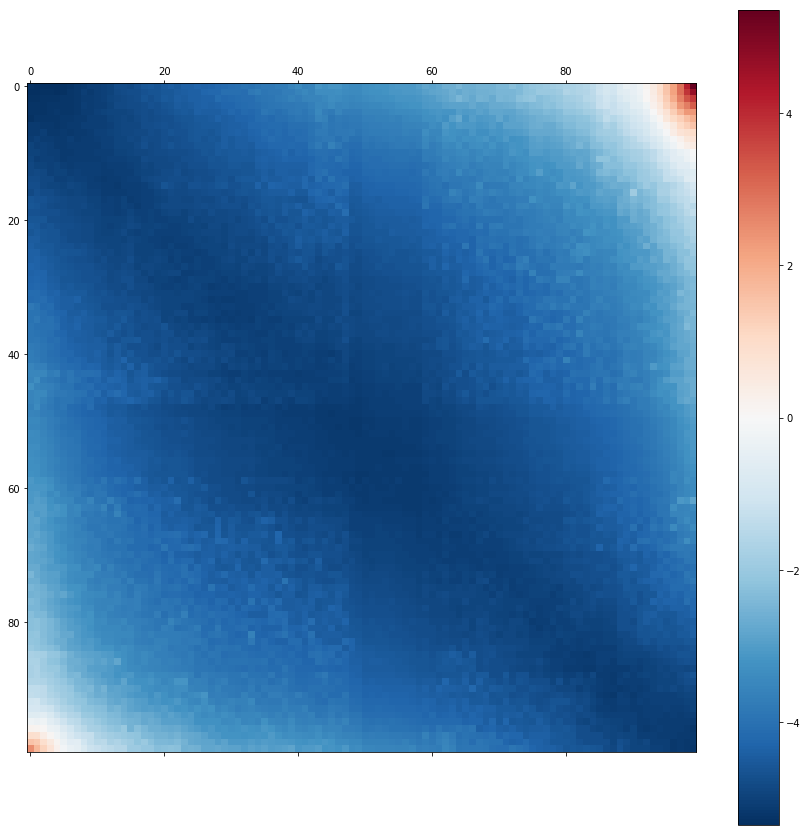

In [10]:
avg_resized = avg_resized_with_window(arr, loop_new_size)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(avg_resized))

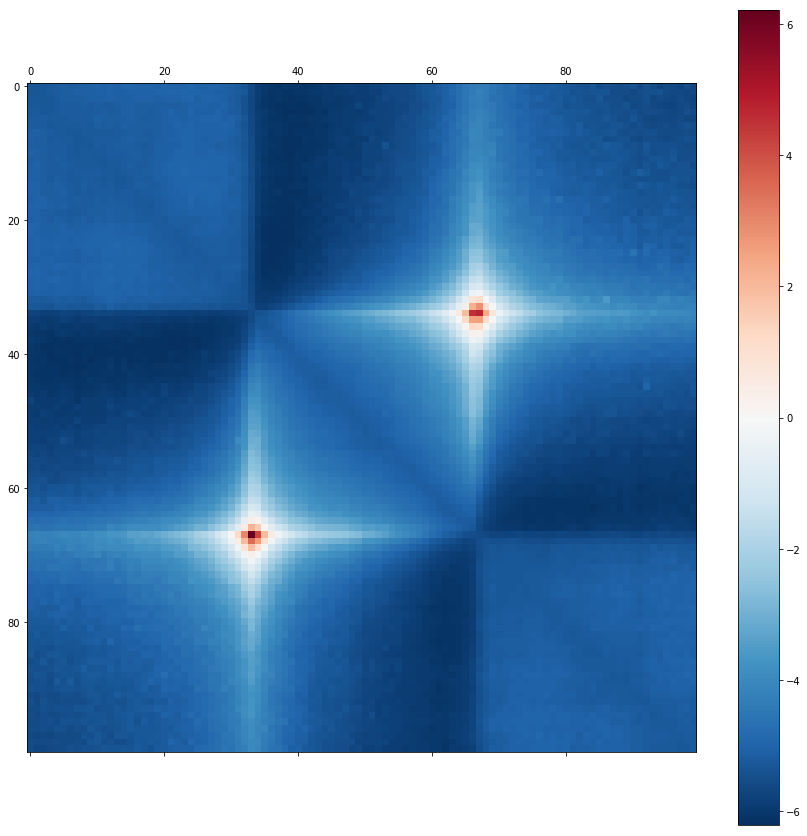

In [11]:
avg_resized = avg_resized_with_window(arr, loop_new_size, True)
loops_utils.plot_HiC(loops_utils.z_norm_zero_middle(avg_resized))

# Scaling

## raw data

In [12]:
arr = np.load('arrs/10kb_chr' + str(chr) + '.npy')

## loops

###### mean

/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:118: RuntimeWarning: Mean of empty slice
  scaling[i] = np.nanmean(np.diagonal(arr, i))
/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:141: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(range(scaling.shape[0])), np.log(scaling), 'b')


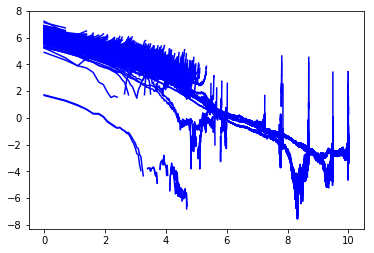

In [13]:
scaling_values = []

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    loop = arr[x1:y1, x2:y2]    
    scaling = loops_utils.calc_scaling_mean(loop)
    scaling_values.append(scaling)
    
loops_utils.plot_scaling_values(scaling_values)

###### sum

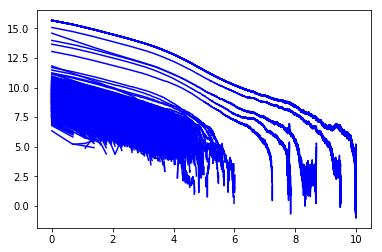

In [14]:
scaling_values = []

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    loop = arr[x1:y1, x2:y2]    
    scaling = loops_utils.calc_scaling_sum(loop)
    scaling_values.append(scaling)
    
loops_utils.plot_scaling_values(scaling_values)

## Loops plus area after

substract loops with sizes between 5- and 95-percentiles

In [15]:
from_percentile = 5
to_percentile = 95

In [16]:
loops_from = np.percentile((loops['y1'] - loops['x1']), from_percentile)
loops_to = np.percentile((loops['y1'] - loops['x1']), to_percentile)
l = loops[(loops['y1'] - loops['x1']) > loops_from]
loops_d = l[(l['y1'] - l['x1']) < loops_to]

In [17]:
max_loop_size = int(np.max(loops_d['y1'] - loops_d['x1']))

In [18]:
max_loop_size

130

In [19]:
def calc_scaling_loop_plus_add_mean(row):
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    loop = arr[x1:y1, x2:y2]
    scaling = loops_utils.calc_scaling_mean(loop)

    add = max_loop_size - (y1 - x1) + 10

    if x1-add > 0 and y1 + add < arr.shape[0]:
        after_loop = np.transpose(arr[y1:y1+add, x1-add:x1])
        after_scaling = np.flip(loops_utils.calc_scaling_mean(after_loop))

        s = np.append(scaling, after_scaling)
    
        return s
    else:
        return None

single

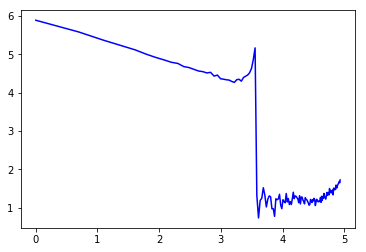

In [20]:
loops_utils.plot_scaling_values([calc_scaling_loop_plus_add_mean(loops_d.iloc[11])])

all

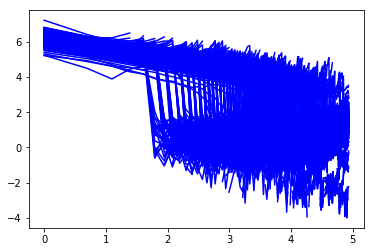

In [21]:
scaling_values = []

for idx, row in loops_d.iterrows():
    scaling = calc_scaling_loop_plus_add_mean(row)
    if scaling is not None:
            scaling_values.append(scaling)
    
loops_utils.plot_scaling_values(scaling_values)

mean

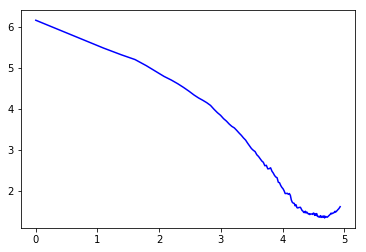

In [22]:
loop_scaling_area_mean = np.nanmean(scaling_values, axis=0)
loops_utils.plot_scaling_values([loop_scaling_area_mean])

## interloops

###### mean

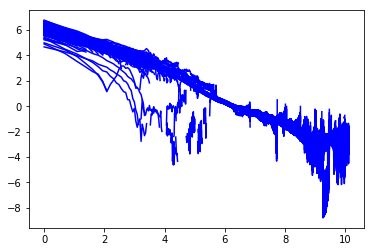

In [23]:
scaling_values = []
        
begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if begin1 < x1 and begin2 < x2:
        a = arr[begin1:x1, begin2:x2]

        scaling = loops_utils.calc_scaling_mean(a)
        scaling_values.append(scaling)
        
    begin1 = y1
    begin2 = y2
        
loops_utils.plot_scaling_values(scaling_values)

###### sum

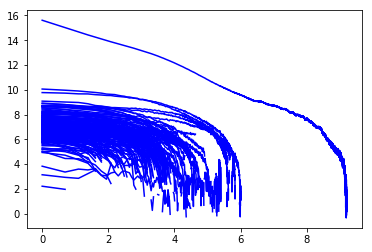

In [24]:
scaling_values = []
        
x_begin = 0
y_begin = 0

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if x_begin < x1 and y_begin < y1:
        a = arr[x_begin:x1, y_begin:y1]
        a[a == -np.inf] = 0

        x_begin = x2
        y_begin = y2

        scaling = loops_utils.calc_scaling_sum(a)
        scaling_values.append(scaling)
        
loops_utils.plot_scaling_values(scaling_values)

## Plus area after

In [25]:
area_size = 200

In [26]:
def calc_scaling_interloops_plus_add_mean(x1,x2,y1,y2):
    a = arr[x1:y1, x2:y2]
    scaling = loops_utils.calc_scaling_mean(a)

    add = area_size - (y1 - x1)

    if x1-add > 0 and y1 + add < arr.shape[0]:
        after_a = np.transpose(arr[y1:y1+add, x1-add:x1])
        after_scaling = np.flip(loops_utils.calc_scaling_mean(after_a))
        s = np.append(scaling, after_scaling)
        return s
    else:
        return None

In [27]:
begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if begin1 < x1 and begin2 < x2 and x1 - begin1 < area_size:
        print(x1-begin1)
        
    begin1 = y1
    begin2 = y2

6
2
8
67
6
25
39
27
15
1
2
1
7
10
2
2
74
1
10
8
6
31
3
4
38
8
31
40
26
27
7
132
6
112
4
3
39
40
10
7
19
16
1
3
8
34
11
16
1
23
3
47
38
8
60
5
4
1
8
15
5
2
35
5
2
3
28
21
8
1
5
4
1
2
2
8
30
3
2
6
3
5
7
6
2
12
4
21
21
40
22
14
1
40
5
11
4
6
47
6
16
7
6
17
22
9
37
5
11
33
6
37
17
10
19
3
8
37
9
4
170
3
4
25
1
16
47
37
62
8
1
31
9
48
3
3
33
15
34
1
10
12
25
6
45
2
18
1
5
64
2
22
2
11
14
29
12
17
2
20
11
4
5
3
88
27
12
11
56
15
17
19
16
31
6
28
14
2
2
3
6
51
35
10
5
5
27
32
91
3
16
11
6
28
13
2
47
3
10
34
25
29
5
37
2
6
71
14
1
9
47
13
1
14
14
24
47
89
9
23
5
3
4
3
2
2
5
32
170
12
78
5
10
37
2
60
1
18
5
32
9
4
95
5
21
7
15
4
25
21
14
6


all

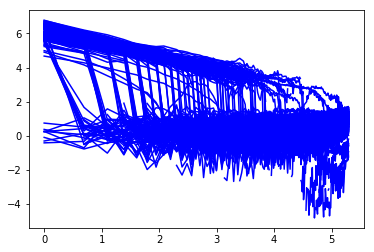

In [28]:
scaling_values = []

begin1 = 0
begin2 = 0

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if begin1 < x1 and begin2 < x2 and x1 - begin1 < area_size:
        scaling = calc_scaling_interloops_plus_add_mean(begin1, begin2, x1, x2)
        if scaling is not None:
            scaling_values.append(scaling)      
        
    begin1 = y1
    begin2 = y2
    
loops_utils.plot_scaling_values(scaling_values)

mean

In [29]:
interloops_scaling_area_mean = np.nanmean(scaling_values, axis=0)

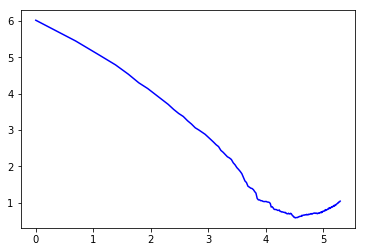

In [30]:
loops_utils.plot_scaling_values([interloops_scaling_area_mean])

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


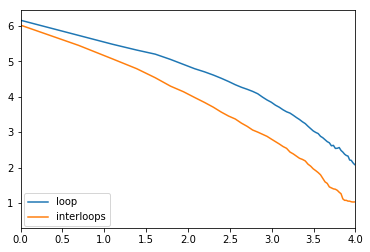

In [38]:
plt.plot(np.log(range(loop_scaling_area_mean.shape[0])), np.log(loop_scaling_area_mean), label='loop');
plt.plot(np.log(range(interloops_scaling_area_mean.shape[0])), np.log(interloops_scaling_area_mean), label='interloops');
plt.xlim(0, 4)
plt.legend(bbox_to_anchor=(0.01, 0.16), loc=2, borderaxespad=0.)
plt.savefig('pictures/rao_avg_scaling.png')

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


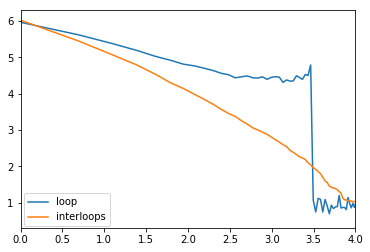

In [40]:
plt.plot(np.log(range(loop_scaling_area_mean.shape[0])), np.log(calc_scaling_loop_plus_add_mean(loops_d.iloc[1])), label='loop');
plt.plot(np.log(range(interloops_scaling_area_mean.shape[0])), np.log(interloops_scaling_area_mean), label='interloops');
plt.xlim(0, 4)
plt.legend(bbox_to_anchor=(0.01, 0.16), loc=2, borderaxespad=0.)
plt.savefig('pictures/rao_avg_vs_one_scaling.png')

## Scaling in one size

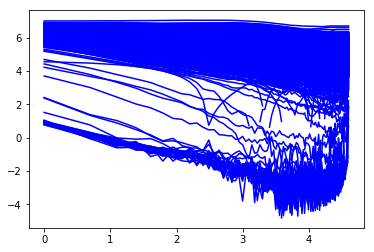

In [41]:
scaling_values = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    original_image = arr[x1:y1, x2:y2]
    resized_image = loops_utils.resize_image_arr(original_image, width, height)
    loop = resized_image
    
    scaling = loops_utils.calc_scaling_mean(loop)
    scaling_values.append(scaling)
    
loops_utils.plot_scaling_values(scaling_values)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


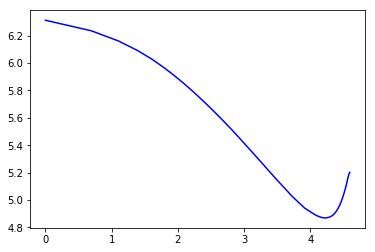

In [42]:
fig = plt.figure()
ax = plt.axes()

sum_scaling = scaling_values[0]

for scaling in scaling_values:
    sum_scaling = sum_scaling + scaling
    
mean_scaling = sum_scaling / len(scaling_values)

plt.plot(np.log(range(mean_scaling.shape[0])), np.log(mean_scaling), 'b');
plt.show()

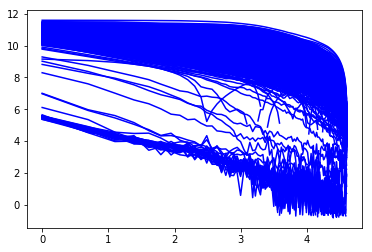

In [43]:
scaling_values = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    original_image = arr[x1:y1, x2:y2]
    scaling = loops_utils.calc_scaling_sum(loops_utils.resize_image_arr(original_image, width, height))
    scaling_values.append(scaling)
    
loops_utils.plot_scaling_values(scaling_values)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


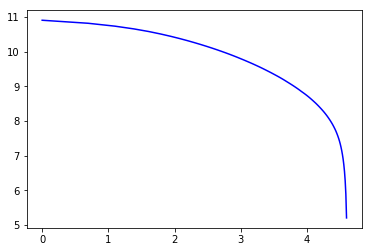

In [44]:
fig = plt.figure()
ax = plt.axes()

sum_scaling = scaling_values[0]

for scaling in scaling_values:
    sum_scaling = sum_scaling + scaling
    
mean_scaling = sum_scaling / len(scaling_values)

plt.plot(np.log(range(mean_scaling.shape[0])), np.log(mean_scaling), 'b');
plt.show()

### interloops

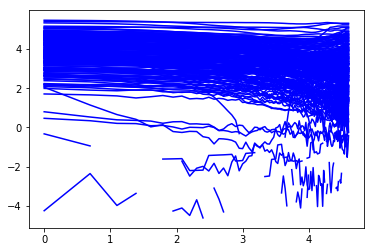

In [45]:
scaling_values = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr[x_begin:x1, y_begin:y1]
        resized_image = loops_utils.resize_image_arr(original_image, width, height)

        x_begin = x2
        y_begin = y2

        scaling = loops_utils.calc_scaling_mean(resized_image)
        scaling_values.append(scaling)
        
loops_utils.plot_scaling_values(scaling_values)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


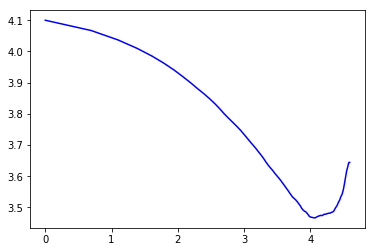

In [46]:
fig = plt.figure()
ax = plt.axes()

sum_scaling = scaling_values[0]

for scaling in scaling_values:
    sum_scaling = sum_scaling + scaling
    
mean_scaling = sum_scaling / len(scaling_values)

plt.plot(np.log(range(mean_scaling.shape[0])), np.log(mean_scaling), 'b');
plt.show()

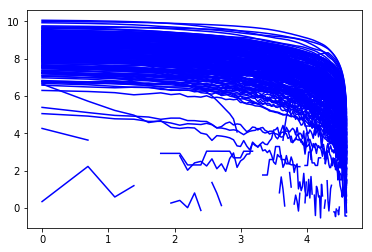

In [47]:
scaling_values = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    x1, x2, y1, y2 = row[['x1', 'x2', 'y1', 'y2']]
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr[x_begin:x1, y_begin:y1]
        resized_image = loops_utils.resize_image_arr(original_image, width, height)
    
        x_begin = x2
        y_begin = y2

        scaling = loops_utils.calc_scaling_sum(resized_image)
        scaling_values.append(scaling)
        
loops_utils.plot_scaling_values(scaling_values)

/anaconda3/envs/loops/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


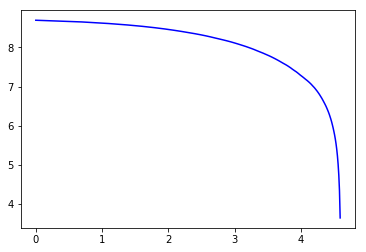

In [48]:
fig = plt.figure()
ax = plt.axes()

sum_scaling = scaling_values[0]

for scaling in scaling_values:
    sum_scaling = sum_scaling + scaling
    
mean_scaling = sum_scaling / len(scaling_values)

plt.plot(np.log(range(mean_scaling.shape[0])), np.log(mean_scaling), 'b');
plt.show()